In [8]:
import torch
import warnings
import os
import sys
from collections import deque

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import gym

In [9]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.ppo import PPO

In [18]:
env = gym.make('CartPole-v1')
rewards_queue = deque()
rewards_ma = list()

max_episodes = 750
max_trajectory_length = 200
discount_factor = 0.99
update_timesteps = 500
num_timesteps = 0


ppo = PPO(
  action_dims = env.action_space.n,
  state_dims = env.observation_space.shape[0],
  actor_lr = 0.001,
  critic_lr = 0.001,
  epsilon_clipping = 0.1,
  optimization_steps = 3,
  discount_rate = 0.99
)

In [19]:
warnings.simplefilter('ignore')
for epi in tqdm(range(max_episodes)):
    state = env.reset()
    total_reward = 0.0

    for t in range(max_trajectory_length):
        num_timesteps += 1
        action, log_prob, state_value = ppo.select_action(torch.from_numpy(state.astype(np.float32)))
        state, reward, is_done, _ = env.step(action)
        ppo.record(state, action, log_prob, state_value, reward, is_done)
        total_reward += reward

        if is_done or update_timesteps == num_timesteps:
            break

    if update_timesteps == num_timesteps:
        ppo.update()
        num_timesteps = 0
        pass

    solved = total_reward > 195.0
    if len(rewards_queue) > 50:
        rewards_queue.popleft()

    rewards_queue.append(total_reward)
    mean_reward = np.mean(rewards_queue)
    rewards_ma.append(mean_reward)

    if solved:
        break

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 605/750 [00:11<00:02, 50.86it/s]


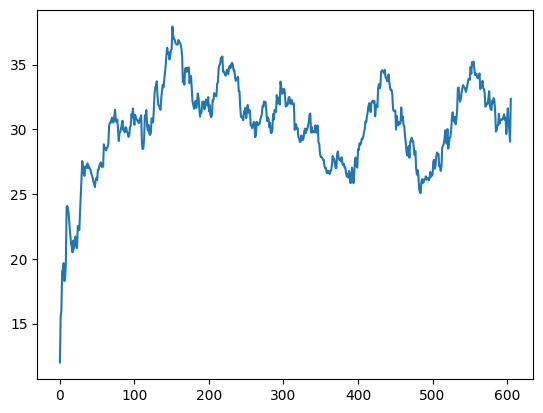

In [21]:
plt.plot(rewards_ma)

In [25]:
ppo.save('./models/ppo-cartpole-v1.pt')